## **Mental Health Stress Detector for Students Using Random Forest**


*   This project uses a Random Forest Classifier to predict student stress levels (0=Low, 1=Medium, 2=High) based on features like `anxiety_level`, `self_esteem`, and `bullying`.

*  We'll preprocess the data, handle missing values, engineer new features, select features using correlations, train the model, evaluate performance, and tune hyperparameters.




# **Loading Dataset**

In [95]:
## Step 1: Importing Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
# Step 2: Importing Dataset
def load_data(file_path="/content/StressLevelDataset.csv"):
    """
    Load the stress dataset from a CSV file.
    """
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("Error: File not found. Please check the file path.")
        return None

#Usage
df = load_data()
if df is None:
    raise SystemExit("Stopping execution due to missing dataset.")

Dataset loaded successfully!
Shape: (1100, 21)


# **Examining Datset and Handling Missing Values**

In [ ]:
# Step 3: Data Examination
def examine_data(df):
    """
    Explore dataset structure and statistics.
    """
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

#Usage
examine_data(df)


First 5 rows:
   anxiety_level  self_esteem  mental_health_history  depression  headache  \
0             14           20                      0          11         2   
1             15            8                      1          15         5   
2             12           18                      1          14         2   
3             16           12                      1          15         4   
4             16           28                      0           7         2   

   blood_pressure  sleep_quality  breathing_problem  noise_level  \
0               1              2                  4            2   
1               3              1                  4            3   
2               1              2                  2            2   
3               3              1                  3            4   
4               3              5                  1            3   

   living_conditions  ...  basic_needs  academic_performance  study_load  \
0                  3  ...      

In [ ]:
# Step 4: Handle Missing Values
def handle_missing_values(df):
    """
    Identify and impute missing values.
    """
    missing = df.isnull().sum()
    print("\nMissing Values Before Imputation:")
    print(missing)

    # If missing values exist, impute with median for numeric columns
    if missing.sum() > 0:
        df = df.fillna(df.median(numeric_only=True))
        print("\nMissing Values After Imputation:")
        print(df.isnull().sum())
    else:
        print("\nNo missing values found!")
    return df

#Usage
df = handle_missing_values(df)


Missing Values Before Imputation:
anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

No missing values found!


# **Feature Engineering**

In [ ]:
# Step 5: Feature Engineering
def engineer_features(df):
    """
    Create new features to enhance model performance, excluding sentiment_score.
    """
    df['mental_health_composite'] = df['anxiety_level'] + df['depression'] + (30 - df['self_esteem'])
    df['social_stress_interaction'] = df['bullying'] * df['peer_pressure']
    print("\nEngineered Features Added:")
    print(df[['mental_health_composite', 'social_stress_interaction']].head())
    return df

df = engineer_features(df)


Engineered Features Added:
   mental_health_composite  social_stress_interaction
0                       35                          6
1                       52                         20
2                       38                          6
3                       49                         20
4                       25                         25


# **Data Preprocessing and Feature Selection**


Correlations with stress_level:
anxiety_level: 0.7368
self_esteem: -0.7562
mental_health_history: 0.6486
depression: 0.7344
headache: 0.7135
blood_pressure: 0.3942
sleep_quality: -0.7491
breathing_problem: 0.5740
noise_level: 0.6634
living_conditions: -0.5817
safety: -0.7096
basic_needs: -0.7090
academic_performance: -0.7209
study_load: 0.6342
teacher_student_relationship: -0.6802
future_career_concerns: 0.7426
social_support: -0.6325
peer_pressure: 0.6907
extracurricular_activities: 0.6930
bullying: 0.7512
mental_health_composite: 0.8337
social_stress_interaction: 0.7748


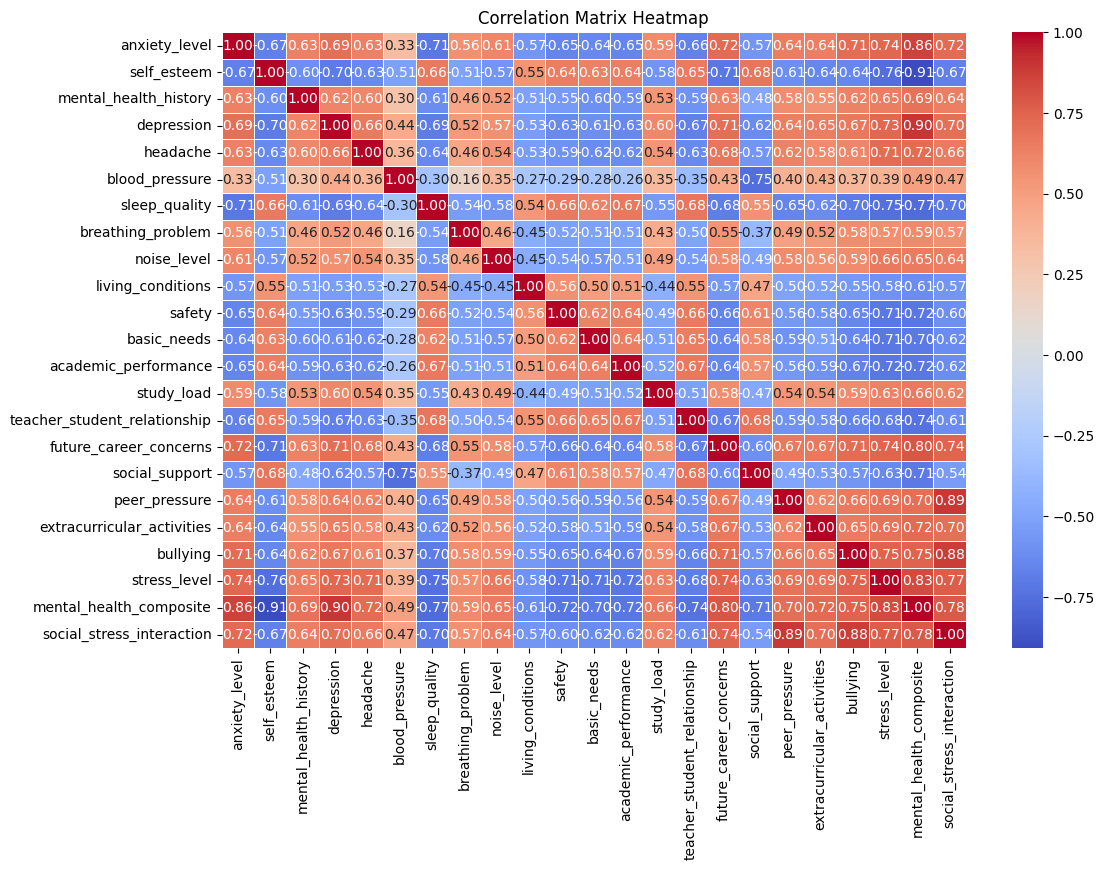


Selected Features (|correlation| >= 0.5): ['mental_health_composite', 'social_stress_interaction', 'self_esteem', 'bullying', 'sleep_quality', 'future_career_concerns', 'anxiety_level', 'depression', 'academic_performance', 'headache', 'safety', 'basic_needs', 'extracurricular_activities', 'peer_pressure', 'teacher_student_relationship', 'noise_level', 'mental_health_history', 'study_load', 'social_support', 'living_conditions', 'breathing_problem']


In [ ]:
# Step 6: Data Preprocessing and Feature Selection
def preprocess_and_select_features(df, target='stress_level', threshold=0.5):
    """
    Preprocess data, compute correlations, visualize them with a heatmap, and select features.
    """
    # Encode categorical variables
    categorical_features = ["future_career_concerns", "safety"]
    encoder = LabelEncoder()
    for col in categorical_features:
        if col in df.columns:  # Check if column exists to avoid errors
            df[col] = encoder.fit_transform(df[col])

    # Compute correlations
    corr_matrix = df.corr()

    # Print correlations with target on separate lines
    correlations = corr_matrix[target].drop(target)  # No .abs() here to show direction
    print(f"\nCorrelations with {target}:")
    for feature, corr in correlations.items():
        print(f"{feature}: {corr:.4f}")

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Select features based on absolute correlation
    abs_correlations = correlations.abs().sort_values(ascending=False)
    selected_features = abs_correlations[abs_correlations >= threshold].index.tolist()

    print(f"\nSelected Features (|correlation| >= {threshold}): {selected_features}")

    return df[selected_features], df[target]

# Usage
X, y = preprocess_and_select_features(df)


In [ ]:
# Step 6.5: Drop Redundant Features
def drop_redundant_features(X):
    """
    Drop specified redundant features from the selected feature set.
    Args:
        X: Feature DataFrame.
    Returns:
        Updated X with dropped columns.
    """
    redundant_features = [
        "anxiety_level", "depression", "self_esteem",  # Replaced by mental_health_composite
        "bullying",  # Requested and part of social_stress_interaction
        "headache", "breathing_problem"  # Moderate correlation
    ]

    # Drop only existing columns to avoid errors
    features_to_drop = [col for col in redundant_features if col in X.columns]
    X = X.drop(columns=features_to_drop, errors="ignore")

    print("\nDropped the following redundant features:")
    print(features_to_drop)

    return X

# Usage
X = drop_redundant_features(X)  # Ensure X is correctly updated



Dropped the following redundant features:
['anxiety_level', 'depression', 'self_esteem', 'bullying', 'headache', 'breathing_problem']


In [ ]:
print(f"Features in X before split: {X.columns.tolist()}")

Features in X before split: ['mental_health_composite', 'social_stress_interaction', 'sleep_quality', 'future_career_concerns', 'academic_performance', 'safety', 'basic_needs', 'extracurricular_activities', 'peer_pressure', 'teacher_student_relationship', 'noise_level', 'mental_health_history', 'study_load', 'social_support', 'living_conditions']


# **Data Splitting**

In [ ]:
# Step 7: Split Data
def split_data(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Apply SMOTE to balance classes
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

#Usage
X_train, X_test, y_train, y_test = split_data(X, y)


Training set shape: (780, 15)
Testing set shape: (330, 15)


# **Training the Model**

In [ ]:
# Step 8: Train Model
def train_model(X_train, y_train, n_estimators=100, max_features='sqrt', random_state=42):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=random_state)
    rf.fit(X_train, y_train)
    print("\nRandom Forest model trained successfully!")
    return rf

#Usage
rf_model = train_model(X_train, y_train)



Random Forest model trained successfully!


**Predicting Results**

In [ ]:
# Step 9: Predicting Results
def predict_results(model, X_test):
    """
    Generate predictions on the test set.
    """
    y_pred = model.predict(X_test)
    return y_pred

#Usage
y_pred = predict_results(rf_model, X_test)
print(y_pred)

[2 0 1 1 0 1 2 0 1 0 0 0 0 2 0 0 0 2 1 0 1 1 0 1 1 2 2 0 0 0 0 2 2 0 0 1 1
 1 2 2 2 0 1 2 2 0 2 2 0 0 1 0 0 0 1 1 2 0 1 1 2 0 1 0 0 0 2 1 2 1 0 1 0 1
 0 2 1 0 1 2 1 0 0 1 1 0 2 2 2 1 0 0 0 1 2 0 0 0 1 1 2 0 0 2 0 1 1 2 1 2 2
 2 1 0 0 2 2 2 0 0 2 1 2 1 2 0 0 2 0 2 2 1 2 0 0 2 1 2 2 2 0 2 0 1 0 1 2 0
 0 2 1 1 2 1 1 1 2 0 2 0 0 0 0 0 1 0 1 2 1 1 1 0 2 2 0 0 0 2 2 0 1 0 1 1 1
 0 0 1 2 1 2 1 2 0 1 1 2 1 1 2 2 1 0 0 1 2 2 2 2 0 0 1 2 0 0 1 2 1 0 1 1 1
 1 1 0 0 1 1 1 0 2 0 2 1 1 2 2 2 0 0 1 0 2 0 0 2 2 1 0 0 0 2 0 2 2 1 1 2 1
 0 0 2 0 1 1 1 2 2 1 0 1 1 2 1 2 0 0 0 1 2 0 1 1 2 1 2 2 1 0 1 0 0 1 0 2 2
 1 1 2 0 0 0 2 2 0 2 0 2 2 2 2 2 1 2 0 1 1 1 1 1 2 2 0 2 0 2 0 0 0 0]


# **Evaluating Performance**


Accuracy: 0.8879

Classification Report:
              precision    recall  f1-score   support

         Low       0.85      0.90      0.88       113
      Medium       0.90      0.89      0.90       107
        High       0.91      0.87      0.89       110

    accuracy                           0.89       330
   macro avg       0.89      0.89      0.89       330
weighted avg       0.89      0.89      0.89       330



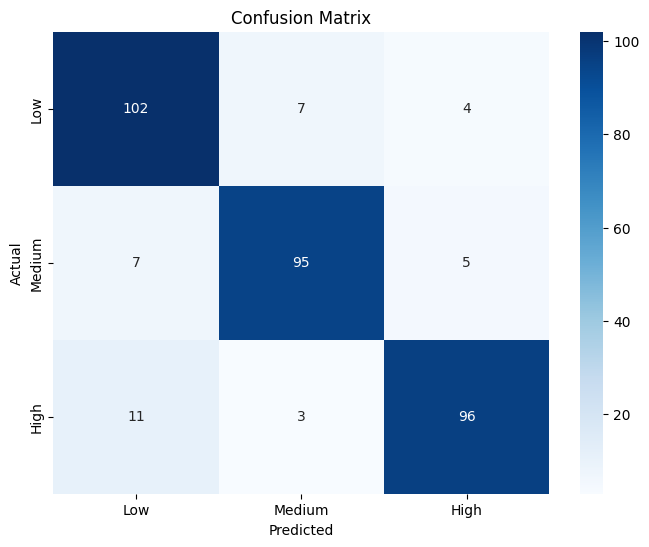

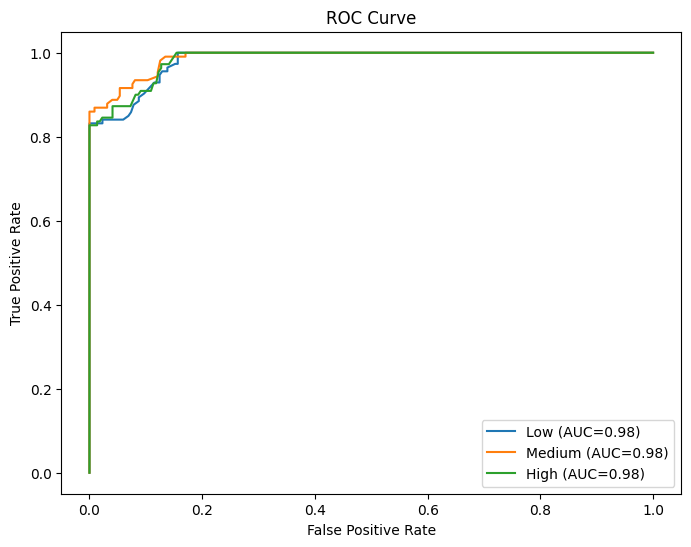

In [ ]:
# Step 10: Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC-AUC Curve
    y_prob = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(['Low', 'Medium', 'High']):
        fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

#Usage
evaluate_model(rf_model, X_test, y_test)

**Inference from the Outputs**

1. **Confusion Matrix:**

      - The model performs well across all three categories (Low, Medium, High).
      - Most predictions are correct, as indicated by the high diagonal values.
      - There are minor misclassifications, but they do not significantly impact performance.

2. **ROC Curve:**
   - The AUC values are 0.98 for all classes, indicating excellent classification performance.
   - The model effectively distinguishes between different classes.

3. **Classification Report & Accuracy:**
   - **Accuracy: 88.79%**, meaning the model correctly predicts almost 89% of instances.
   - **Precision, Recall, and F1-score** are all high across all categories, showing balanced performance.

**Overall Conclusion**
The model is highly effective, achieving strong accuracy and AUC scores. Some misclassifications exist, but they are minimal.

-

# **Visualizing Feature Importance**

Number of features in X: 15
Number of importances from model: 15

Feature Importance (Selected Features):
                         Feature  Importance
1      social_stress_interaction    0.117846
3         future_career_concerns    0.110473
0        mental_health_composite    0.110103
9   teacher_student_relationship    0.093371
2                  sleep_quality    0.090187
5                         safety    0.084195
7     extracurricular_activities    0.074710
13                social_support    0.072504
8                  peer_pressure    0.063354
6                    basic_needs    0.058669
4           academic_performance    0.044717
10                   noise_level    0.029968
12                    study_load    0.022655
14             living_conditions    0.015580
11         mental_health_history    0.011667


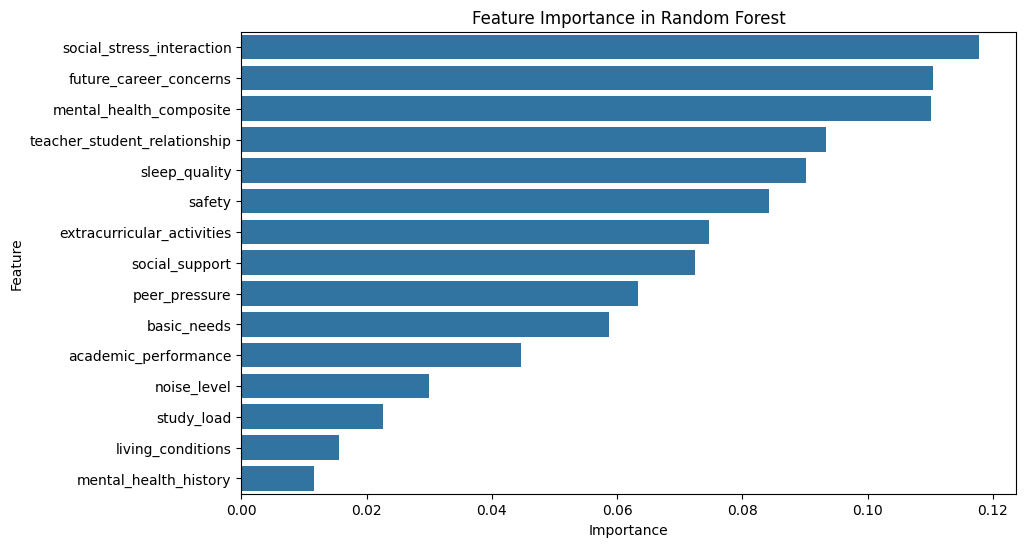

In [ ]:
# Cell 11: Visualizing Feature Importance
def plot_feature_importance(model, X):
    """
    Visualize feature importance from the Random Forest model.
    Args:
        model: Trained Random Forest model
        X: DataFrame with the same features used to train the model
    """
    importances = model.feature_importances_
    feature_names = X.columns

    # Debug: Check lengths
    print(f"Number of features in X: {len(feature_names)}")
    print(f"Number of importances from model: {len(importances)}")

    # Ensure lengths match
    if len(feature_names) != len(importances):
        raise ValueError(f"Length mismatch: feature_names ({len(feature_names)}) and importances ({len(importances)}) must be the same length.")

    # Create DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    print("\nFeature Importance (Selected Features):")
    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance in Random Forest')
    plt.show()

# Usage
plot_feature_importance(rf_model, X)

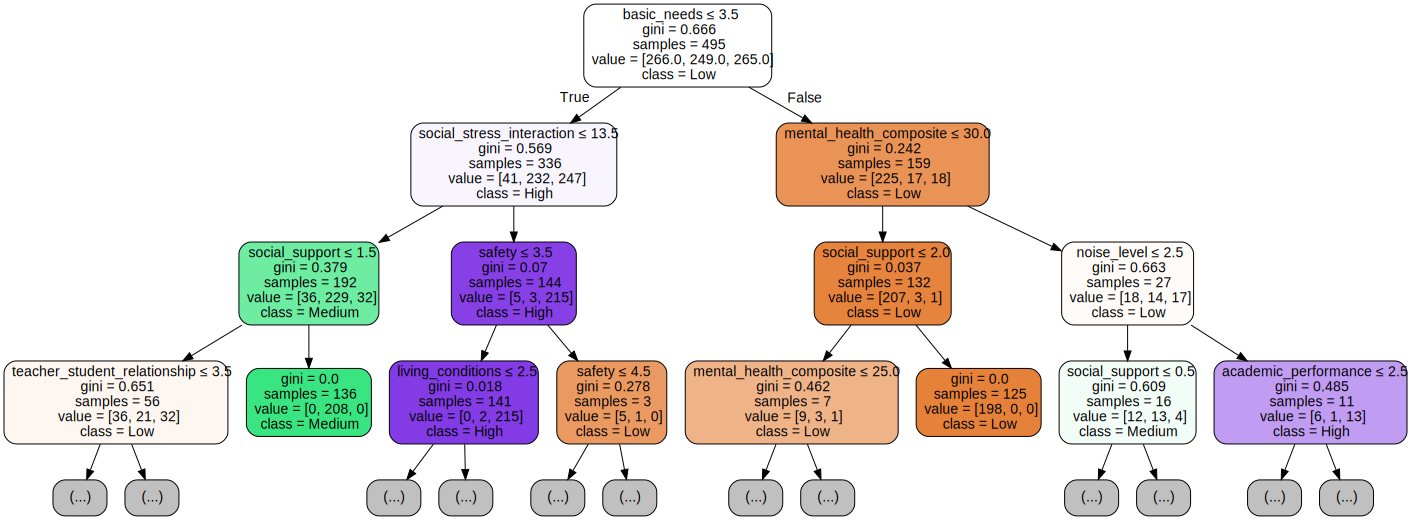

In [ ]:
# Step 6: Visualizing a Random Forest Tree
def visualize_rf_tree(model, feature_names, class_names=['Low', 'Medium', 'High'], max_depth=3):
    estimator = model.estimators_[0]
    dot_data = export_graphviz(
        estimator,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth
    )
    graph = graphviz.Source(dot_data)
    graph.render("random_forest_tree", view=True, format='png')
    return graph

visualize_rf_tree(rf_model, X.columns)

**📊 Interpretation of the Decision Tree**

This decision tree provides insights into how different factors contribute to the classification of students into different stress levels (Low, Medium, or High). Here's what it tells us:

  **1️⃣ Root Node (Most Important Feature)**

      - **Feature: `basic_needs ≤ 3.5`**
        - This means **basic needs** (such as food, shelter, and security) are the most important predictor of stress levels.
        - If a student’s basic needs score is **low (≤3.5)**, they are more likely to experience **higher stress**.

**2️⃣ Major Splits & Their Meaning**

      - **If `basic_needs > 3.5` (right side)**:
        - The next key factor is **`mental_health_composite ≤ 30`**.
        - Students with **better mental health (composite > 30)** are less likely to experience high stress.
        - Those with **lower mental health scores (≤30)** continue splitting into other factors such as `social_support` and `noise_level`.

      - **If `basic_needs ≤ 3.5` (left side)**:
        - The next major factor is **`social_stress_interaction ≤ 13.5`**.
        - Students experiencing **higher social stress (greater than 13.5)** are more likely to fall into the **high stress** category.

**3️⃣ Key Observations**

      - **Social support plays a crucial role**:
        - If `social_support > 1.5`, it helps reduce stress (leading to Medium stress classification).
        - If `social_support ≤ 1.5`, students are more likely to have high stress.
        
      - **Safety and living conditions also influence stress**:
        - Higher safety scores reduce stress.
        - Poor living conditions (`living_conditions ≤ 2.5`) are associated with **higher stress**.
        
      - **Academic performance and noise levels have minor influence**:
        - Lower academic performance and higher noise levels are associated with increased stress, but these features appear lower in the tree, meaning they have **less predictive power** than basic needs, social stress, and mental health.

**📌 Implications & Actionable Insights**

      - **Improving basic needs (food, security, housing) should be a priority** to reduce stress.
      - **Enhancing social support** can significantly lower stress levels.
      - **Providing mental health resources and stress management programs** can help mitigate high stress.
      - **Better living conditions and a safer environment can contribute to overall well-being**.


# **Hyperparameter Tuning**

In [ ]:
# Step 7: Hyperparameter Tuning
def tune_hyperparameters(X_train, y_train):
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    print("\nBest Parameters from RandomizedSearchCV:")
    print(random_search.best_params_)

    return random_search.best_estimator_

#Usage
best_model = tune_hyperparameters(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters from RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 10}


### **🔍 Interpretation of `RandomizedSearchCV` Output for Hyperparameter Tuning**

The output provides details on the **best hyperparameters** selected for your model after tuning. Here’s what it tells us:


  **1️⃣ What Happened?**
  - **5-fold cross-validation**: The dataset was split into **5 subsets**, and the model was trained/tested on different combinations to get a reliable performance estimate.
  - **10 candidate parameter sets**: `RandomizedSearchCV` tested **10 different random hyperparameter combinations**.
  - **50 total fits**: Since there were **5 folds per combination**, a total of **10 × 5 = 50** fits were performed.



 **2️⃣ Best Hyperparameters Found**
  - **`n_estimators`: 200**
   - The best number of trees in the forest is **200**.
   - Increasing trees generally improves performance but also increases training time.

  - **`min_samples_split`: 5**
   - A node must have at least **5 samples** to be split further.
   - This prevents **overfitting** by ensuring splits occur only if there's sufficient data.

  - **`max_features`: 'sqrt'**
   - The number of features considered at each split is **the square root of total features**.
   - This is a common choice for **Random Forests**, balancing performance and speed.

  - **`max_depth`: 10**
   - The decision trees are limited to **a depth of 10**.
   - This helps **reduce overfitting** while maintaining model complexity.



 **📌 What This Means for Your Model**

  - The hyperparameters were tuned to **balance accuracy and generalization**.  
  - The model will likely have **better performance on unseen data**.  
  - It **reduces overfitting** by restricting tree depth and requiring more samples per split.  



# **VISUALIZING A TREE**

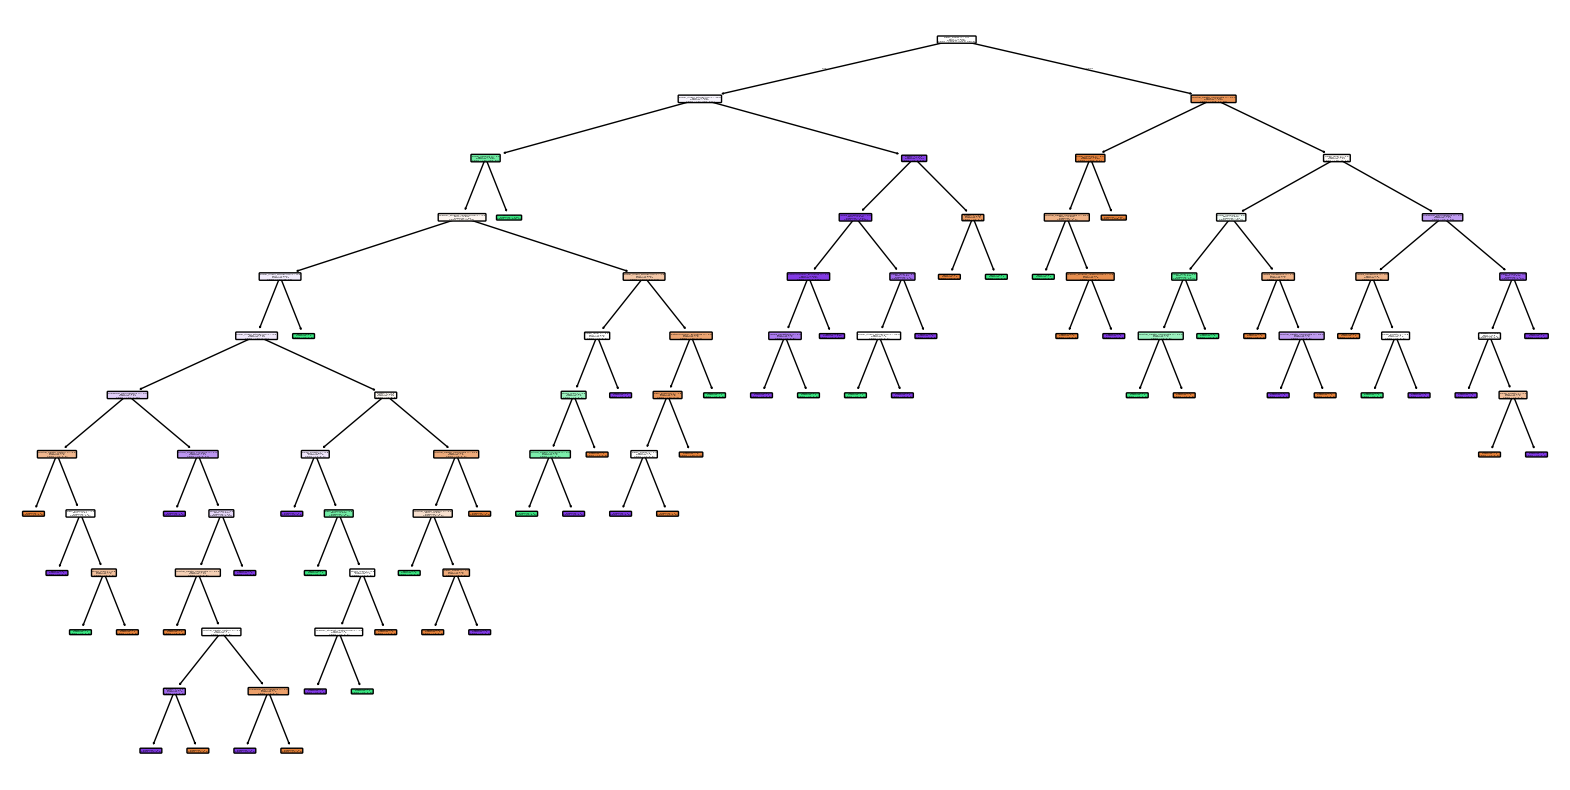

In [96]:
# Extract one tree from the Random Forest
single_tree = rf_model.estimators_[0]  # Get the first tree

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(single_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

In [97]:
tree_rules = export_text(single_tree, feature_names=list(X_train.columns))
print(tree_rules)

|--- basic_needs <= 3.50
|   |--- social_stress_interaction <= 13.50
|   |   |--- social_support <= 1.50
|   |   |   |--- teacher_student_relationship <= 3.50
|   |   |   |   |--- social_stress_interaction <= 9.00
|   |   |   |   |   |--- social_stress_interaction <= 3.50
|   |   |   |   |   |   |--- academic_performance <= 0.50
|   |   |   |   |   |   |   |--- mental_health_history <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- mental_health_history >  0.50
|   |   |   |   |   |   |   |   |--- peer_pressure <= 2.00
|   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |   |--- peer_pressure >  2.00
|   |   |   |   |   |   |   |   |   |--- study_load <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- study_load >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- academic_performance >  0.50
|   |   |   |   |   |   |   |--- fu